# Phys 581 Winter 2019
# Assignment #5: Multiprocessing
## Alexander Hickey, 10169582

In [1]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import signal, subprocess
import psutil
%matplotlib inline

### Introduction

Parallel computing allows one to harness the processing power of a multi-core computer, and can significantly decrease the time required for repetitive computations. The idea behind parallel computing is to take a large problem and divide it into smaller ones which can be solved simultaneously, and allocate these different tasks to different parts of the CPU network. Often times, it is very powerful to implement parallel computing in the framework of scientific computations, to allow researchers to execute code and analyze output within a reasonable timeframe.

In [2]:
print( psutil.cpu_stats(), '\n' )
print( psutil.cpu_times(), '\n' )
print( psutil.cpu_times_percent(interval=1, percpu=False), '\n' )
print( 'number of physical(?) CPUs: ', psutil.cpu_count(), '\n' )
print( psutil.cpu_times_percent(interval=1, percpu=True), '\n' )
print(sys.argv)

scpustats(ctx_switches=49135140, interrupts=41185143, soft_interrupts=0, syscalls=539195004) 

scputimes(user=1753.203125, system=1177.78125, idle=106774.984375, interrupt=74.53125, dpc=63.984375) 

scputimes(user=1.2, system=1.0, idle=97.7, interrupt=0.2, dpc=0.0) 

number of physical(?) CPUs:  8 

[scputimes(user=0.0, system=1.5, idle=96.9, interrupt=1.5, dpc=0.0), scputimes(user=1.6, system=0.0, idle=95.3, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=1.6, idle=98.4, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=0.0, idle=98.4, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=0.0, idle=100.0, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=0.0, idle=98.4, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=0.0, idle=100.0, interrupt=0.0, dpc=0.0), scputimes(user=0.0, system=1.6, idle=96.9, interrupt=0.0, dpc=0.0)] 

['C:\\Users\\Admin\\Miniconda3\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Admin\\AppData\\Roaming\\jupyter\\runtime\\kernel-8002f3

In [3]:
def cpu_idle(nloop=999):
    """ simple example of signal handling
    """
    cpu_idle.flag = nloop
    
    def handler(signum, frame):
        print('Signal handler called with signal ',signum)
        #signal.alarm(0)
        cpu_idle.flag = 0
        
    signal.signal(signal.SIGINT, handler)

    while cpu_idle.flag > 0:
        cpu_idle.flag -= 1
        cpu = psutil.cpu_times_percent(interval=1, percpu=True)
        print('\t'.join([str(c.idle) for c in cpu]))

In [4]:
# make a simple CPU intensive task
#
cmnd = '[i**2 for i in range(9876543)]'
%timeit exec(cmnd)

2.25 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# spawn a subprocess to execute the task
#
status = subprocess.check_output('python -c "[i**2 for i in range(9876)]; print(True)"',shell=True)
print('subprocess status: ', status)

subprocess status:  b'True\n'


In [6]:
cmnd = 'python -c "[i**2 for i in range(9876543)]; print(True)"'
import time
def paralize(cmdlist, nwait=100, nicer=False):
    
    plist = []
    for n, cmd in enumerate(cmdlist):
        plist.append( subprocess.Popen(cmnd, shell=True) ) 
#        print( plist[-1].pid )
#        if nicer and n >= psutil.cpu_count():
#            print('nice: ', psutil.Process( plist[-1].pid ).nice(-10) ) # set priority not supported under Windows
    
    tlist = {}
    n0 = time.time()
    for i in range(nwait):
        
        time.sleep(0.1)
        
        for n,p in enumerate(plist):    
            try:
                parent = psutil.Process(pid=p.pid)
        
                child = parent.children()[0]
                
                if child is None:# or len(child)< 1:
                    continue
                proc = psutil.Process(pid=child.pid)
                
                cputime = proc.cpu_times().user
                
                tlist[p.pid] = [time.time()-n0,cputime]
        
            except:
                None
                
        
    return tlist
        
dat = paralize([cmnd for j in range(8)])

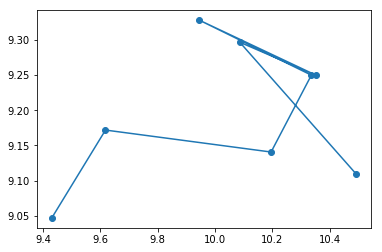

In [7]:
t =[]
for key in dat:
    t.append(dat[key])
t = np.array(t)

plt.plot(t[:,0],t[:,1],marker= 'o')

In [8]:
np.sum(t[:,1])/np.mean(t[:,0])

7.317507441242123

In [ ]:
# run three subprocesses in parallel
#
paralize([cmnd for i in range(3)], nwait=500)

In [8]:
# run one process for each CPU
#
paralize([cmnd for i in range(8)], nwait=10)

0 1.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7
1 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7
2 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7
3 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7
4 0.0	0.0	0.0	0.0 4,5,6,7
5 92.0	93.0	91.0	95.1 
6 99.0	99.0	98.0	99.0 
7 99.0	99.0	99.0	99.0 
8 99.0	97.0	99.0	99.0 
9 97.0	98.0	99.0	96.1 


In [9]:
# oversubscribing by 50% takes slightly longer
#
paralize([cmnd for i in range(12)], nwait=10)

0 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
1 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
2 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
3 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
4 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
5 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
6 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11
7 8.0	4.0	8.9	7.0 
8 99.0	98.0	99.0	99.0 
9 99.0	99.0	98.0	98.0 


In [10]:
paralize([cmnd for i in range(24)], nwait=15)

0 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
1 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
3 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
4 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
5 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
6 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
7 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
8 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
9 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
10 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
11 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
12 0.0	0.0	0.0	0.0 0,1,2,3,4,5,6,7,8,9

### Task: determine scaling efficiency
Gather estimates of computation as a function of number of processes, plot, and analyze.

Ideally we would have a perfectly linear relationship up to the number of CPUs and constant thereafter.  In practice the slope will be less than one and may saturate earlier.

In [32]:
cmdlist = [cmnd for j in range(5)]
for n, cmd in enumerate(cmdlist):
    print(n,cmd)

0 python -c "[i**2 for i in range(9876543)]; print(True)"
1 python -c "[i**2 for i in range(9876543)]; print(True)"
2 python -c "[i**2 for i in range(9876543)]; print(True)"
3 python -c "[i**2 for i in range(9876543)]; print(True)"
4 python -c "[i**2 for i in range(9876543)]; print(True)"


In [91]:
cmnd = 'python -c "[i**2 for i in range(9876543)]; print(True)"'

def cpu_calls(cmdlist, t_interval= 1e-3):
    
    plist = []
    for cmd in cmdlist:
        plist.append(subprocess.Popen(cmnd, shell=True)) 
    
    no_process = [0 for j in plist]
    nwait = 0
    active = []
    
    while active != no_process:
        cpu = psutil.cpu_times_percent(interval=t_interval, percpu=True)
        active = [p.poll() for p in plist]
        nwait += 1
        
    return nwait
        
    
num = np.arange(1,20)
wait = []
for n in num:
    
    wait.append(cpu_calls([cmnd for i in range(n)]))

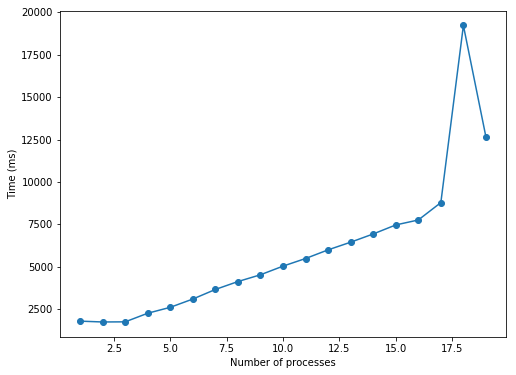

In [95]:
plt.figure(figsize=(8,6))
plt.plot(num,wait,marker = 'o')
plt.xlabel('Number of processes')
plt.ylabel('Time (ms)')

plt.show()

### Task: Use the multiprocessing package to speed up hyperparameter optimization.    

### Figure out how to get this working on a single computer 

### Figure out how to get this working on all of the ST026 computers 

### Conclusion